In [3]:
from datetime import datetime, timedelta, date
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from __future__ import division

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
!pip install chart_studio
from chart_studio import plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

     |████████████████████████████████| 64 kB 2.4 MB/s 


In [6]:
import keras
from keras.layers import Dense
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [7]:
pyoff.init_notebook_mode()

Output hidden; open in https://colab.research.google.com to view.

In [8]:
df_sales = pd.read_csv('output.csv')

In [10]:
df_sales.dtypes

Sale_Date                      object
Receipt_ID                      int64
Customer_ID                    object
Customer_First_Name            object
Customer_Surname               object
Staff_ID                       object
Staff_First_Name               object
Staff_Surname                  object
Staff_Office                    int64
Office_Location                object
Receipt_Transaction_Row_ID      int64
Item_ID                         int64
Item_Description               object
Item_Quantity                   int64
Item_Price                    float64
Row_Total                     float64
dtype: object

In [11]:
df_sales.head(10)

,Sale_Date,Receipt_ID,Customer_ID,Customer_First_Name,Customer_Surname,Staff_ID,Staff_First_Name,Staff_Surname,Staff_Office,Office_Location,Receipt_Transaction_Row_ID,Item_ID,Item_Description,Item_Quantity,Item_Price,Row_Total
0,2020-01-19 00:00:00.000,114557,C14,Zoe,Peterson,S96,Peter,James,3,Tammworth,7,9,Box of Screws,3,12.50,37.50
1,2020-01-19 00:00:00.000,114557,C14,Zoe,Peterson,S96,Peter,James,3,Tammworth,8,21,Drill Bit 4 mm,7,3.25,22.75
2,2020-01-19 00:00:00.000,114557,C14,Zoe,Peterson,S96,Peter,James,3,Tammworth,9,26,Drill Bit 9 mm,10,3.75,37.50
3,2020-01-19 00:00:00.000,115007,C525,Jesse,Fisher,S20,Dylan,Hall,1,Newcastle,1,15,Picture Hook,7,8.95,62.65
4,2020-01-19 00:00:00.000,115007,C525,Jesse,Fisher,S20,Dylan,Hall,1,Newcastle,2,19,Drill Bit 2 mm,8,3.00,24.00
5,2020-01-19 00:00:00.000,115007,C525,Jesse,Fisher,S20,Dylan,Hall,1,Newcastle,3,11,Grinder,4,69.90,279.60
6,2020-01-19 00:00:00.000,115007,C525,Jesse,Fisher,S20,Dylan,Hall,1,Newcastle,4,17,Punch,4,12.00,48.00
7,2020-01-19 00:00:00.000,115007,C525,Jesse,Fisher,S20,Dylan,Hall,1,Newcastle,5,13,Ruler,10,21.90,219.00
8,2020-01-19 00:00:00.000,115437,C191,Laura,Mitchell,S187,Savannah,Jones,8,Wollongong,1,16,Socket Set,1,79.95,79.95
9,2020-01-19 00:00:00.000,115437,C191,Laura,Mitchell,S187,Savannah,Jones,8,Wollongong,2,17,Punch,7,12.00,84.00


In [12]:
df_sales = df_sales[['Sale_Date', 'Row_Total']]
df_sales['Sale_Date'] = pd.to_datetime(df_sales['Sale_Date'])
df_sales.head(10)

,Sale_Date,Row_Total
0,2020-01-19,37.50
1,2020-01-19,22.75
2,2020-01-19,37.50
3,2020-01-19,62.65
4,2020-01-19,24.00
5,2020-01-19,279.60
6,2020-01-19,48.00
7,2020-01-19,219.00
8,2020-01-19,79.95
9,2020-01-19,84.00


In [13]:
#df_sales = df_sales[['Sale_Date', 'Row_Total']]
df_sales = df_sales.set_index('Sale_Date')
df_sales = df_sales.Row_Total.resample('W').sum()
df_sales = pd.DataFrame(df_sales).reset_index()
df_sales.tail(10)


,Sale_Date,Row_Total
43,2020-11-01,215481.05
44,2020-11-08,194842.30
45,2020-11-15,262839.60
46,2020-11-22,254718.05
47,2020-11-29,241238.00
48,2020-12-06,237640.90
49,2020-12-13,230965.60
50,2020-12-20,226740.85
51,2020-12-27,227634.50
52,2021-01-03,94031.80


In [14]:
#tried to add
#start = datetime(2021, 1, 10)
#future_dates = pd.DataFrame(pd.date_range(start, periods = 10, freq="W"), columns = ['Sale_Date'])
#df_sales = df_sales.append(future_dates).reset_index(drop=True)
#df_sales.tail(20)

In [15]:
#represent month in date field as its first day
# df_sales['Sale_Date'] = df_sales['Sale_Date'].dt.year.astype('str') + '-W' + df_sales['Sale_Date'].dt.month.astype('str') + '-01'
#df_sales['Sale_Date'] = pd.to_datetime(df_sales['Sale_Date'])
#groupby date and sum the sales
#df_sales = df_sales.groupby('Sale_Date').Row_Total.sum().reset_index()
#df_sales.head()

In [16]:
#plot monthly sales
plot_data = [
    go.Scatter(
        x=df_sales['Sale_Date'],
        y=df_sales['Row_Total'],
    )
]

plot_layout = go.Layout(
        title='Weekly Sales'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [17]:
#create a new dataframe to model the difference
df_diff = df_sales.copy()

In [18]:
#add previous sales to the next row
df_diff['prev_sales'] = df_diff['Row_Total'].shift(1)

In [19]:
df_diff.tail()

,Sale_Date,Row_Total,prev_sales
48,2020-12-06,237640.90,241238.00
49,2020-12-13,230965.60,237640.90
50,2020-12-20,226740.85,230965.60
51,2020-12-27,227634.50,226740.85
52,2021-01-03,94031.80,227634.50


In [20]:
#drop the null values and calculate the difference
df_diff = df_diff.dropna()

In [21]:
df_diff['diff'] = (df_diff['Row_Total'] - df_diff['prev_sales'])

In [22]:
df_diff.tail(10)

,Sale_Date,Row_Total,prev_sales,diff
43,2020-11-01,215481.05,220206.25,-4725.20
44,2020-11-08,194842.30,215481.05,-20638.75
45,2020-11-15,262839.60,194842.30,67997.30
46,2020-11-22,254718.05,262839.60,-8121.55
47,2020-11-29,241238.00,254718.05,-13480.05
48,2020-12-06,237640.90,241238.00,-3597.10
49,2020-12-13,230965.60,237640.90,-6675.30
50,2020-12-20,226740.85,230965.60,-4224.75
51,2020-12-27,227634.50,226740.85,893.65
52,2021-01-03,94031.80,227634.50,-133602.70


In [23]:
#plot sales diff
plot_data = [
    go.Scatter(
        x=df_diff['Sale_Date'],
        y=df_diff['diff'],
    )
]

plot_layout = go.Layout(
        title='Weekly Sales Diff'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [24]:
#create new dataframe from transformation from time series to supervised
df_supervised = df_diff.drop(['prev_sales'],axis=1)

In [25]:
#adding lags
for inc in range(1,13):
    field_name = 'lag_' + str(inc)
    df_supervised[field_name] = df_supervised['diff'].shift(inc)

In [26]:
df_supervised.head(10)

,Sale_Date,Row_Total,diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
1,2020-01-12,245114.10,86354.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-19,231169.10,-13945.00,86354.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-26,225055.25,-6113.85,-13945.00,86354.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-02-02,237488.45,12433.20,-6113.85,-13945.00,86354.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2020-02-09,211694.40,-25794.05,12433.20,-6113.85,-13945.00,86354.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2020-02-16,242064.50,30370.10,-25794.05,12433.20,-6113.85,-13945.00,86354.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2020-02-23,211094.85,-30969.65,30370.10,-25794.05,12433.20,-6113.85,-13945.00,86354.35,NaN,NaN,NaN,NaN,NaN,NaN
8,2020-03-01,238228.50,27133.65,-30969.65,30370.10,-25794.05,12433.20,-6113.85,-13945.00,86354.35,NaN,NaN,NaN,NaN,NaN
9,2020-03-08,231778.70,-6449.80,27133.65,-30969.65,30370.10,-25794.05,12433.20,-6113.85,-13945.00,86354.35,NaN,NaN,NaN,NaN
10,2020-03-15,247567.80,15789.10,-6449.80,27133.65,-30969.65,30370.10,-25794.05,12433.20,-6113.85,-13945.00,86354.35,NaN,NaN,NaN


In [27]:
df_supervised.tail(6)

,Sale_Date,Row_Total,diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
47,2020-11-29,241238.00,-13480.05,-8121.55,67997.30,-20638.75,-4725.20,-21290.45,14703.05,15280.90,26819.75,-61630.45,31367.75,-22770.50,-7177.80
48,2020-12-06,237640.90,-3597.10,-13480.05,-8121.55,67997.30,-20638.75,-4725.20,-21290.45,14703.05,15280.90,26819.75,-61630.45,31367.75,-22770.50
49,2020-12-13,230965.60,-6675.30,-3597.10,-13480.05,-8121.55,67997.30,-20638.75,-4725.20,-21290.45,14703.05,15280.90,26819.75,-61630.45,31367.75
50,2020-12-20,226740.85,-4224.75,-6675.30,-3597.10,-13480.05,-8121.55,67997.30,-20638.75,-4725.20,-21290.45,14703.05,15280.90,26819.75,-61630.45
51,2020-12-27,227634.50,893.65,-4224.75,-6675.30,-3597.10,-13480.05,-8121.55,67997.30,-20638.75,-4725.20,-21290.45,14703.05,15280.90,26819.75
52,2021-01-03,94031.80,-133602.70,893.65,-4224.75,-6675.30,-3597.10,-13480.05,-8121.55,67997.30,-20638.75,-4725.20,-21290.45,14703.05,15280.90


In [28]:
#drop null values
df_supervised = df_supervised.dropna().reset_index(drop=True)

In [29]:
# Import statsmodels.formula.api
import statsmodels.formula.api as smf 

# Define the regression formula
model = smf.ols(formula='diff ~ lag_1', data=df_supervised)

# Fit the regression
model_fit = model.fit()

# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj
print(regression_adj_rsq)

0.11196491856496948


In [30]:
# Import statsmodels.formula.api
import statsmodels.formula.api as smf 

# Define the regression formula
model = smf.ols(formula='diff ~ lag_1 + lag_2 + lag_3 + lag_4 + lag_5 + lag_6', data=df_supervised)

# Fit the regression
model_fit = model.fit()

# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj
print(regression_adj_rsq)

0.13201677469477446


In [31]:
# Import statsmodels.formula.api
import statsmodels.formula.api as smf 

# Define the regression formula
model = smf.ols(formula='diff ~ lag_1 + lag_2 + lag_3 + lag_4 + lag_5 + lag_6 + lag_7 + lag_8 + lag_9 + lag_10 + lag_11 + lag_12', data=df_supervised)

# Fit the regression
model_fit = model.fit()

# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj
print(regression_adj_rsq)

0.23656001752027944


In [32]:
#import MinMaxScaler and create a new dataframe for LSTM model
from sklearn.preprocessing import MinMaxScaler
df_model = df_supervised.drop(['Row_Total','Sale_Date'],axis=1)

In [33]:
#split train and test set 25 train, 15 test
train_set, test_set = df_model[0:-15].values, df_model[-15:].values

In [34]:
train_set.shape

(25, 13)

In [35]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   diff    40 non-null     float64
 1   lag_1   40 non-null     float64
 2   lag_2   40 non-null     float64
 3   lag_3   40 non-null     float64
 4   lag_4   40 non-null     float64
 5   lag_5   40 non-null     float64
 6   lag_6   40 non-null     float64
 7   lag_7   40 non-null     float64
 8   lag_8   40 non-null     float64
 9   lag_9   40 non-null     float64
 10  lag_10  40 non-null     float64
 11  lag_11  40 non-null     float64
 12  lag_12  40 non-null     float64
dtypes: float64(13)
memory usage: 4.2 KB


In [36]:
#apply Min Max Scaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_set)
# reshape training set
train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
train_set_scaled = scaler.transform(train_set)

# reshape test set
test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
test_set_scaled = scaler.transform(test_set)

In [37]:
X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])

In [38]:
X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print(X_train.shape[1])

1


In [39]:
model = Sequential()
model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['accuracy'])
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1, shuffle=False)

Epoch 1/100
25/25 [==============================] - 2s 2ms/step - loss: 0.2764 - accuracy: 0.0000e+00
Epoch 2/100
25/25 [==============================] - 0s 1ms/step - loss: 0.2768 - accuracy: 0.0000e+00
Epoch 3/100
25/25 [==============================] - 0s 2ms/step - loss: 0.2636 - accuracy: 0.0000e+00
Epoch 4/100
25/25 [==============================] - 0s 2ms/step - loss: 0.2547 - accuracy: 0.0000e+00
Epoch 5/100
25/25 [==============================] - 0s 2ms/step - loss: 0.2485 - accuracy: 0.0000e+00
Epoch 6/100
25/25 [==============================] - 0s 2ms/step - loss: 0.2438 - accuracy: 0.0000e+00
Epoch 7/100
25/25 [==============================] - 0s 2ms/step - loss: 0.2399 - accuracy: 0.0000e+00
Epoch 8/100
25/25 [==============================] - 0s 3ms/step - loss: 0.2365 - accuracy: 0.0000e+00
Epoch 9/100
25/25 [==============================] - 0s 2ms/step - loss: 0.2335 - accuracy: 0.0000e+00
Epoch 10/100
25/25 [==============================] - 0s 2ms/step - loss:

In [40]:
y_pred = model.predict(X_test,batch_size=1)

In [41]:
y_pred

array([[-0.55647683],
       [ 0.47390914],
       [-0.11496224],
       [ 0.12270723],
       [-0.76812285],
       [-0.57854503],
       [-0.4226794 ],
       [ 0.25066212],
       [-1.1139163 ],
       [-0.03640001],
       [-0.20175967],
       [-0.06556949],
       [-0.06455635],
       [-0.14046316],
       [-0.125119  ]], dtype=float32)

In [42]:
y_test

array([[-1.32069432],
       [ 0.31558985],
       [ 0.10212693],
       [ 0.091437  ],
       [-0.57442463],
       [-0.26797585],
       [-0.56236851],
       [ 1.0773538 ],
       [-0.33080661],
       [-0.42993616],
       [-0.24710656],
       [-0.30405171],
       [-0.25871777],
       [-0.16402995],
       [-2.65214472]])

In [43]:
#reshape y_pred
y_pred = y_pred.reshape(y_pred.shape[0], 1, y_pred.shape[1])

In [44]:
#rebuild test set for inverse transform
pred_test_set = []
for index in range(0,len(y_pred)):
    print(np.concatenate([y_pred[index],X_test[index]],axis=1))
    pred_test_set.append(np.concatenate([y_pred[index],X_test[index]],axis=1))

[[-0.55647683  0.39972556 -0.58106009 -0.29633875 -0.39664775  0.56511645
  -0.43438095  0.32930702 -0.58799612 -0.61097987  0.14099711  0.04384616
  -0.27378623]]
[[ 0.47390914 -1.32069432  0.40749962 -0.58106009 -0.29633875 -0.39664775
   0.56511645 -0.43438095  0.32930702 -0.58799612 -0.61097987  0.14099711
  -0.13429445]]
[[-0.11496224  0.31558985 -1.29063938  0.40749962 -0.58106009 -0.29633875
  -0.39664775  0.56511645 -0.43438095  0.32930702 -0.58799612 -0.61097987
  -0.05372308]]
[[ 0.12270723  0.10212693  0.32445354 -1.29063938  0.40749962 -0.58106009
  -0.29633875 -0.39664775  0.56511645 -0.43438095  0.32930702 -0.58799612
  -0.67736923]]
[[-0.76812285  0.091437    0.11375515  0.32445354 -1.29063938  0.40749962
  -0.58106009 -0.29633875 -0.39664775  0.56511645 -0.43438095  0.32930702
  -0.65830784]]
[[-0.57854503 -0.57442463  0.10320366  0.11375515  0.32445354 -1.29063938
   0.40749962 -0.58106009 -0.29633875 -0.39664775  0.56511645 -0.43438095
   0.10245025]]
[[-0.42267939 -0

In [45]:
pred_test_set[0]

array([[-0.55647683,  0.39972556, -0.58106009, -0.29633875, -0.39664775,
         0.56511645, -0.43438095,  0.32930702, -0.58799612, -0.61097987,
         0.14099711,  0.04384616, -0.27378623]])

In [46]:
#reshape pred_test_set
pred_test_set = np.array(pred_test_set)
pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])

In [47]:
#inverse transform
pred_test_set_inverted = scaler.inverse_transform(pred_test_set)

In [48]:
#create dataframe that shows the predicted sales
result_list = []
sales_dates = list(df_sales[-16:].Sale_Date)
act_sales = list(df_sales[-16:].Row_Total)
for index in range(0,len(pred_test_set_inverted)):
    result_dict = {}
    result_dict['pred_value'] = int(pred_test_set_inverted[index][0] + act_sales[index])
    result_dict['Sale_Date'] = sales_dates[index+1]
    result_list.append(result_dict)
df_result = pd.DataFrame(result_list)

In [49]:
df_result.tail(6)
pred_test_set_inverted

array([[-20320.27227362,  31367.75      , -22770.5       ,
         -7177.8       , -12671.2       ,  39999.6       ,
        -14737.65      ,  27085.55      , -23150.35      ,
        -24409.05      ,  16772.8       ,  11452.35      ,
          2241.15      ],
       [ 35377.78234517, -61630.45      ,  31367.75      ,
        -22770.5       ,  -7177.8       , -12671.2       ,
         39999.6       , -14737.65      ,  27085.55      ,
        -23150.35      , -24409.05      ,  16772.8       ,
         11452.35      ],
       [  3546.03102687,  26819.75      , -61630.45      ,
         31367.75      , -22770.5       ,  -7177.8       ,
        -12671.2       ,  39999.6       , -14737.65      ,
         27085.55      , -23150.35      , -24409.05      ,
         16772.8       ],
       [ 16393.37889208,  15280.9       ,  26819.75      ,
        -61630.45      ,  31367.75      , -22770.5       ,
         -7177.8       , -12671.2       ,  39999.6       ,
        -14737.65      ,  27085.55   

In [50]:
df_sales.head()

,Sale_Date,Row_Total
0,2020-01-05,158759.75
1,2020-01-12,245114.10
2,2020-01-19,231169.10
3,2020-01-26,225055.25
4,2020-02-02,237488.45


In [51]:
#merge with actual sales dataframe
df_sales_pred = pd.merge(df_sales,df_result,on='Sale_Date',how='left')

In [52]:
df_sales_pred

,Sale_Date,Row_Total,pred_value
0,2020-01-05,158759.75,NaN
1,2020-01-12,245114.10,NaN
2,2020-01-19,231169.10,NaN
3,2020-01-26,225055.25,NaN
4,2020-02-02,237488.45,NaN
5,2020-02-09,211694.40,NaN
6,2020-02-16,242064.50,NaN
7,2020-02-23,211094.85,NaN
8,2020-03-01,238228.50,NaN
9,2020-03-08,231778.70,NaN


In [53]:
#plot actual and predicted
plot_data = [
    go.Scatter(
        x=df_sales_pred['Sale_Date'],
        y=df_sales_pred['Row_Total'],
        name='actual'
    ),
        go.Scatter(
        x=df_sales_pred['Sale_Date'],
        y=df_sales_pred['pred_value'],
        name='predicted'
    )
    
]

plot_layout = go.Layout(
        title='Sales Prediction'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [54]:
!pip install prophet
import pandas as pd
from prophet import Prophet

df_prof = df_sales.copy().rename(columns={"Sale_Date": "ds", "Row_Total": "y"})
df_prof = df_prof[df_prof['ds']!='2021-01-03']


     |████████████████████████████████| 65 kB 2.9 MB/s 
     |████████████████████████████████| 49 kB 5.9 MB/s 
     |████████████████████████████████| 214 kB 24.5 MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6640643 sha256=97514e288d23460d67069e7e1828c9db04cdfe33dc31e56d29aef3cad38764c5
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.


In [55]:
m = Prophet(weekly_seasonality=True)
m.fit(df_prof)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [56]:
future = m.make_future_dataframe(freq = "W", periods=13)
future.tail()

,ds
60,2021-02-28
61,2021-03-07
62,2021-03-14
63,2021-03-21
64,2021-03-28


In [57]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
60,2021-02-28,235217.040907,209364.677838,262775.120835
61,2021-03-07,235389.191927,207900.416336,260129.743806
62,2021-03-14,235561.342948,210586.001747,260365.745138
63,2021-03-21,235733.493968,210046.576200,260864.210849
64,2021-03-28,235905.644989,209561.668598,263531.455344


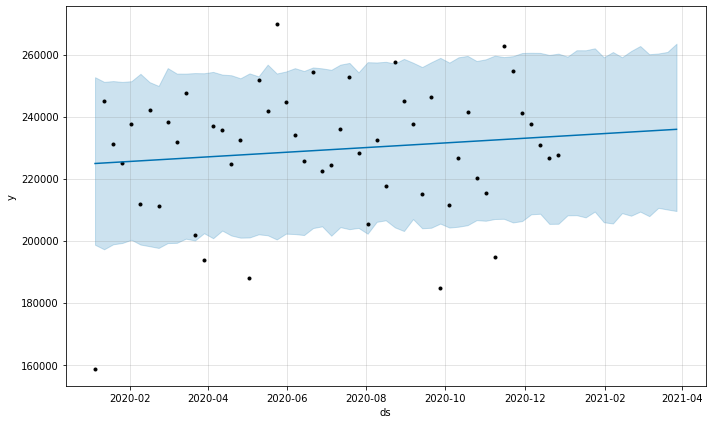

In [58]:
fig1 = m.plot(forecast)


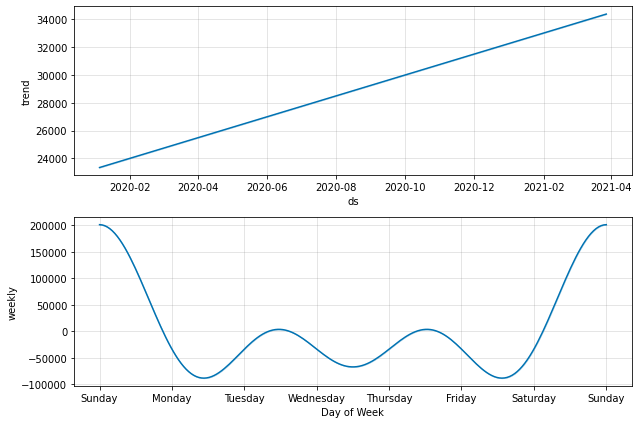

In [59]:
fig2 = m.plot_components(forecast)


In [60]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

In [61]:
plot_components_plotly(m, forecast)